## Test tf applications

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
from globalVariables import *
import simpleCNNwithInception as inceptionCNN
import simpleCNN as simpleCNN
import simpleCNNwithInceptionRegression as regressor
from keras.callbacks import CSVLogger
from scipy.ndimage import rotate
from tools import plot_confusion_matrix
from getSIDMdata_generator_meta import get_tf_DataSet as getGenerators
import scienceplots
plt.style.use(["science", "grid"])
from tools import get_best_model 
from tqdm import tqdm

#### Fiducial

In [ ]:
simulationNames = ['CDM','SIDM0.1','SIDM1']
nClasses = len(simulationNames)
epochs=80

In [ ]:
model_names = ['simple','dibare','inception']
monte_carlo_histories = [] #A record of the histories of the modelling
simulationNames = ['CDM','SIDM0.1','SIDM1']
nDM_Models = len(simulationNames)
monte_carlo = 1
for imodel in model_names:
    for i in tqdm(range(monte_carlo)):
        train, test = getGenerators(augment_data=True, simulationNames=simulationNames, 
                                                      channels=['total','stellar','xray'], 
                                                      allDataFile='pickles/binned_data_20.pkl', random_state=i)
        if not os.path.isdir( 'models/%s' % (imodel)):
            os.system("mkdir -p models/%s" % (imodel))
            
        checkpoint_filepath = 'models/%s/%i' % (imodel, i)
  
        model = get_best_model( train, test, model_name=imodel, checkpoint_filepath=checkpoint_filepath)
    
        monte_carlo_histories.append( model.history.history )
pkl.dump(open("architecture_test.pkl","wb"))

In [ ]:
pkl.dump(monte_carlo_histories, open("pickles/test_arch.pkl","wb"))

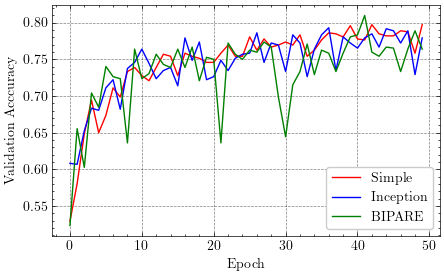

In [27]:
plt.figure(figsize=(5,3))
plt.xlabel('Epoch')
plt.ylabel('Validation Acccuracy')

c = ['r','b','g','c','y','k']
name=['Simple','Inception','BIPARE']
models = pkl.load(open("pickles/test_arch.pkl","rb"))


for i, iModel in enumerate(models):
    plt.plot(np.arange(len(iModel['val_accuracy'])), iModel['val_accuracy'], label=name[i], c=c[i])
    #plt.plot(iModel.history.epoch, [np.max(iModel.history.history['val_accuracy'])]*len(iModel.history.epoch), c=c[i])
    #print(np.max(iModel.history.history['val_accuracy']))

plt.legend()
plt.savefig("../plots/architecture_test.pdf")

## Various resenets that dont really work since the interpolation to larger images fucks things

In [ ]:
def setup_resnet_wrapper( inputShape, resnet):
    
    inputLayer = Input(shape=inputShape)
    model = resnet(inputLayer)
    model = tf.keras.layers.Flatten( )( model )
    model = layers.Dense(128, activation='relu')( model )
    model = tf.keras.layers.Dense(4)(model)
    finalModel = Model(inputLayer, model)
    finalModel.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
    
    return finalModel

#### 1. Resnet 50

In [ ]:
inputShape = train_a[0][0].shape[1:]
resnet_50 = resnet.ResNet50( classes=4, weights=None, include_top=False, pooling='max', input_shape=inputShape)
resenet_50_model = setup_resnet_wrapper( inputShape, resnet_50 )

In [ ]:
resnet_50_history = resenet_50_model.fit(
      x=train_a,
        validation_data=test_a,
      epochs=epochs, verbose=1 )

#### 2. Resnet 50 v2

In [ ]:
from tensorflow.keras.applications import resnet_v2

In [ ]:
inputShape = train_a[0][0].shape[1:]
resnet_50_v2= resnet_v2.ResNet50V2( classes=4, weights=None, include_top=False, pooling='max', input_shape=inputShape, classifier_activation=None)
resnet_50_v2_model = setup_resnet_wrapper( inputShape, resnet_50_v2 )

In [ ]:
epochs=20
au_history = resnet_50_v2_model.fit(
      x=train_a,
        validation_data=test_a,
      epochs=epochs, verbose=1 )

#### 2. Resnet 50 v2 with imagenet weights

In [ ]:
inputShape = train_a[0][0].shape[1:] = dataset_to_numpy[0][0].shape[1:]

In [ ]:
resnet_50_v2= resnet_v2.ResNet50V2( pooling='max' )

In [ ]:

# add a global spatial average pooling layer
x = resnet_50_v2.output
# let's add a fully-connected layer
x = tf.keras.layers.Dense(1024, activation='relu')(x)
# and a logistic layer -- let's say we have 200 classes
predictions = tf.keras.layers.Dense(4)(x)

# this is the model we will train
model = Model(inputs=resnet_50_v2.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in resnet_50_v2.layers:
    layer.trainable = False
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
au_history = model.fit(
      x=train_a,
        validation_data=test_a,
      epochs=epochs, verbose=1 )